# Flow-Shop Scheduling

In [384]:
import pandas as pd
import random
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

In [443]:
def get_problem(filepath):
    with open(filepath) as f:
        firstline = f.readline().rstrip()
        nums = firstline.split(" ")     
    data = pd.read_csv(filepath, sep= " ", header=None, skiprows=1)
    return data, nums

def df_to_schedule(data, nums):
    data = data.to_numpy()
    jobs = []
    for row in data:
        jobs.append(Job(row))
    schedule = Schedule(jobs, int(nums[1]))
    return schedule
    

2742
2714
2601
2571
2567
2537
2534
2528
2503


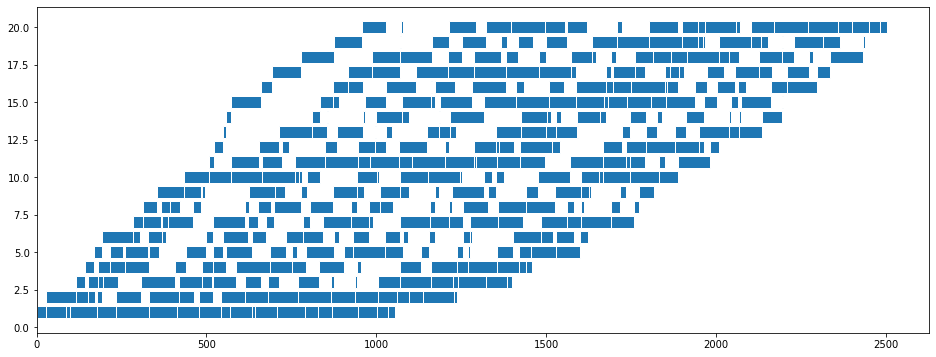

2503


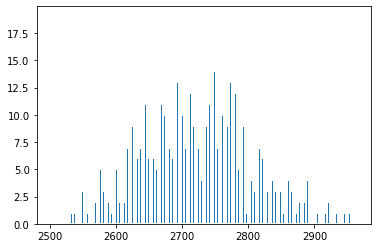

In [458]:
df, nums = get_problem("dataset/ta030.txt")
makespan_list = []
best = None
best_t = 10000000
for i in range(500):
    s = df_to_schedule(df, nums)
    s.randomPermutation()
    s.update_times()
    makespan_list.append(s.makespan())
    if (s.makespan() < best_t):
        print(s.makespan())
        best_t = s.makespan()
        best = s

        

gantt_chart(best)
makespan_hist(makespan_list)

In [455]:
def gantt_chart(schedule):
#     c_dict = {1:'red', 2:'blue', 3: 'yellow', 4:'green', 5: "orange", 6: "black", 7:"purple", 8: "grey"}
#     def color(row):
#         return c_dict[row['job']]
    df = schedule.get_df()
#     df['color'] = df.apply(color, axis=1)
#     legend_elements = [Patch(facecolor=c_dict[i], label=i)  for i in c_dict]
    df['width'] = (df.end-df.start)
    fig, ax = plt.subplots(1, figsize=(16,6))
    ax.barh(df.machine, df.width, left=df.start, edgecolor='white')
#     plt.legend(handles=legend_elements)
    plt.show()
    print(schedule.makespan())

In [353]:
def iteration_vs_makespan(makespan_list):
    x = [x for x in range(1, len(makespan_list) +1)]
    plt.scatter(x, makespan_list)

In [354]:
def makespan_hist(makespan_list):
    binwidth = 4
    plt.hist(makespan_list, bins=range(min(makespan_list), max(makespan_list) + binwidth, binwidth), linewidth=2,
             edgecolor='white')

In [362]:
class Schedule():
    def __init__(self, jobs, num_machines):
        self.jobs = jobs
        self.m = num_machines
        
        # MxN array
        self.machines = []
        
        for i, job in enumerate(self.jobs):
            for j, task in enumerate(job.tasks):
                task.ID = (i+1, j+1)
    
    def randomGenome(self):
        for m in range(self.m):
            self.machines.append([])
            for i, job in enumerate(self.jobs):
                if(job.n > m):
                    self.machines[m].append(job.tasks[m])
            random.shuffle(self.machines[m])
            
    def randomPermutation(self):
        job_order = [job for job in self.jobs]
        random.shuffle(job_order)
        
        for m in range(self.m):
            self.machines.append([])
            for i, job in enumerate(job_order):
                if(job.n > m):
                    self.machines[m].append(job.tasks[m])    
         
    def update_times(self):
        # First operation on each
        track = self.machines[0]
        track[0].set_start(0)
        for i in range(1, len(track)):
            track[i].set_start(track[i-1].end)
             
        for machine in self.machines[1:]:
            for i, task in enumerate(machine):
                if i == 0:
                    task.set_start(task.parent.end)
                else:
                    #start is the max of parent.end and i-1 End
                    legal_start = max(task.parent.end, machine[i-1].end)
                    task.set_start(legal_start)
        
    def print_times(self):
        for machine in self.machines:
            track_schedule = ""
            for task in machine:
                track_schedule += f"{task.start} - {task.end} |"
            print(track_schedule)
            
    def get_df(self):
        df = {"job" : [], "task": [],  "start": [], "end": [], "machine": []}
        count = 1
        for i, machine in enumerate(self.machines):
            for task in machine:
                df["job"].append(task.ID[0])
                df["task"].append(task.ID[1])
                df["start"].append(task.start)
                df["end"].append(task.end)
                df["machine"].append(i+1)
                count += 1
        return pd.DataFrame(data=df)
    
    def makespan(self):
        return self.machines[-1][-1].end
                    


In [183]:
class Job():
    def __init__(self, length_per_task):
        self.n = len(length_per_task)
        self.tasks = []
        self.start = 0
        self.end = 0
        #Linked list of task hierarchy
        for length in length_per_task:
            self.tasks.append(Task(None, length))
        for i in range(1, len(self.tasks)):
            self.tasks[i].parent = self.tasks[i-1]
                                           

In [4]:
class Task():
    def __init__(self, parent, length):
        self.parent = parent # Task that preceedes this
        self.length = length # How long task will take
        self.ID = (0, 0)
        
    def __str__(self):
        return str(self.ID)
    
    def set_start(self, start):
        self.start = start
        self.end = start + self.length